In [1]:
%run ../_config/config.py # Import the configuration settings
import itertools
import logging
import statistics as stat
from scipy import stats
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from scipy import stats
import seaborn as sns

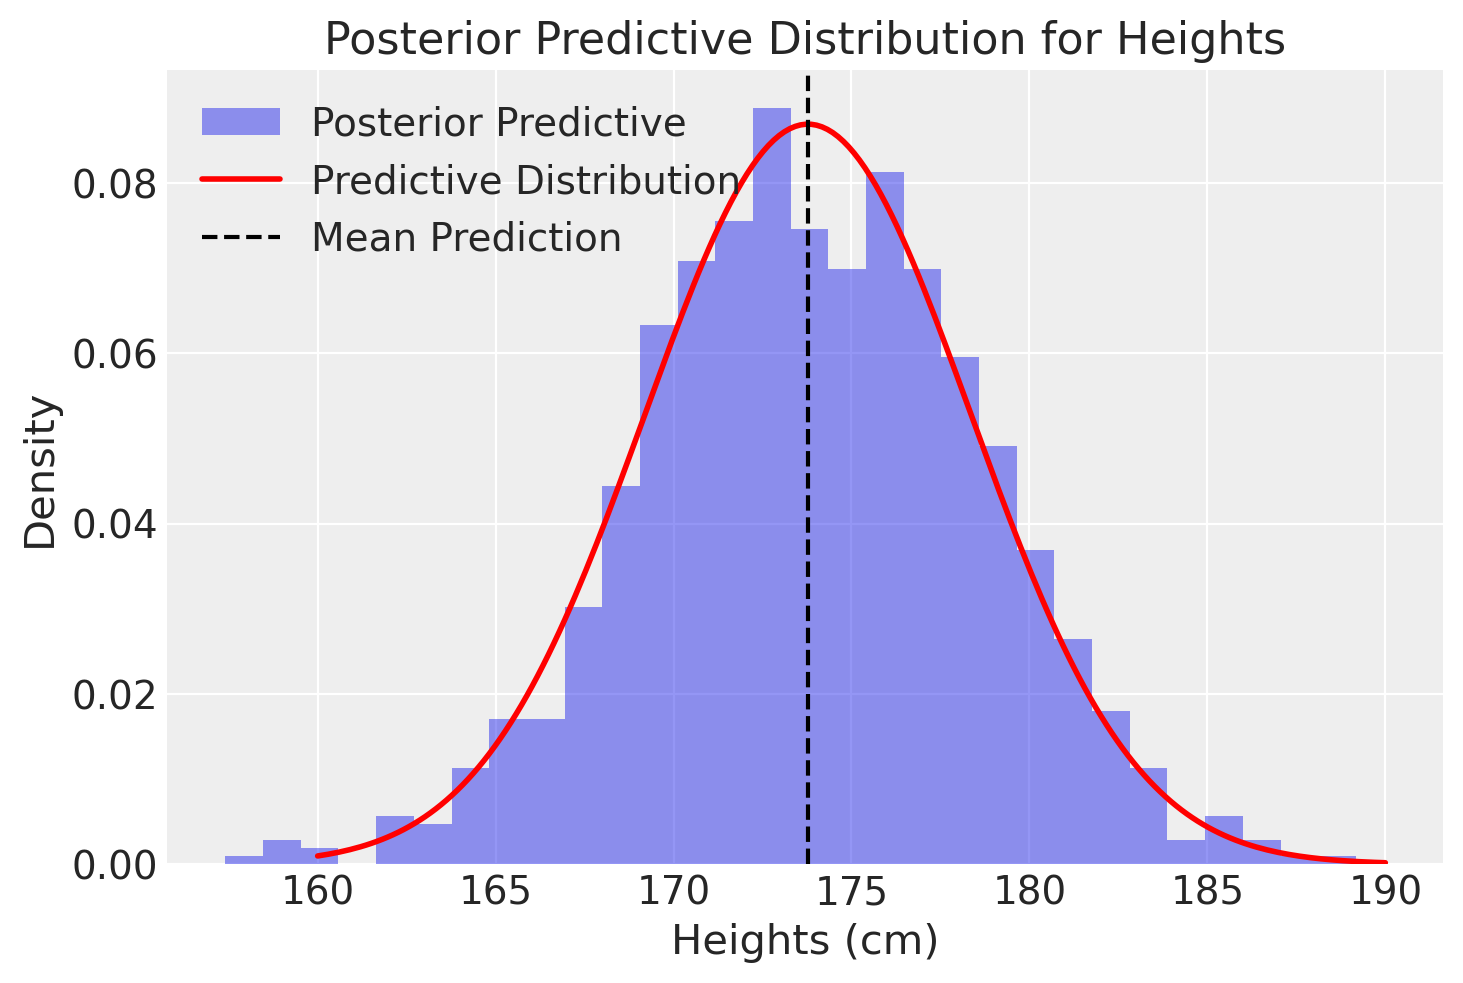

In [2]:
# Dati osservati
y_observed = np.random.normal(170, 10, 100)
mean_y = np.mean(y_observed)
std_y = np.std(y_observed)

# Parametri a priori
mu_0 = 175
tau_0 = 5

# Parametri posteriori
tau_n_sq = (tau_0**2 * std_y**2) / (tau_0**2 + std_y**2)
tau_n = np.sqrt(tau_n_sq)
mu_n = (tau_0**2 * mean_y + std_y**2 * mu_0) / (tau_0**2 + std_y**2)

# Parametri predittivi
n_fut = 100
sigma_pred_sq = tau_n_sq + (std_y**2 / n_fut)
sigma_pred = np.sqrt(sigma_pred_sq)
mu_pred = mu_n

# Simulazioni
y_pred_samples = np.random.normal(mu_pred, sigma_pred, 1000)

# Grafico
plt.hist(y_pred_samples, bins=30, density=True, alpha=0.5, label='Posterior Predictive')
x = np.linspace(160, 190, 200)
plt.plot(x, stats.norm.pdf(x, mu_pred, sigma_pred), 'r-', lw=2, label='Predictive Distribution')
plt.axvline(x=mu_pred, color='k', linestyle='--', label='Mean Prediction')
plt.xlabel('Heights (cm)')
plt.ylabel('Density')
plt.title('Posterior Predictive Distribution for Heights')
plt.legend()
plt.show()

In [3]:
stan_ncp_file = os.path.join(
    project_directory, 'stan', 'gaussian_ncp.stan')

model_ncp = CmdStanModel(stan_file=stan_ncp_file)

In [4]:
print(model_ncp.code())

data {
    int<lower=1> N;
    vector[N] y;
}
transformed data {
    real y_mean = mean(y);
    real y_sd = sd(y);
}
parameters {
    real mu_raw;
    real<lower=0> sigma_raw;
}
transformed parameters {
    real mu;
    real<lower=0> sigma;
    mu = y_mean + y_sd * mu_raw;
    sigma = y_sd * sigma_raw;
}
model {
    // Priors:
    mu_raw ~ normal(0, 1);
    sigma_raw ~ normal(0, 1);
    // Likelihood:
    y ~ normal(mu, sigma);
}
generated quantities {
    vector[N] y_rep;
    for (n in 1:N) {
        y_rep[n] = normal_rng(mu, sigma);
    }
}



In [5]:
stan_data = {
    'N': len(y_observed), 
    'y': y_observed
}

print(stan_data)

{'N': 100, 'y': array([171.96581381, 164.47710641, 157.91426703, 158.32818828,
       163.86028418, 173.36934944, 154.07963372, 164.40764344,
       163.18301734, 174.07557036, 179.96191717, 189.1043359 ,
       172.31037122, 166.12502256, 160.60694872, 171.15798161,
       158.69657965, 157.21990299, 178.62771666, 160.35962282,
       162.28151759, 163.61569088, 151.0949321 , 169.40645352,
       147.87575638, 166.19409576, 149.31394323, 154.11754244,
       152.62083154, 182.28170464, 159.26720722, 171.56296352,
       182.05327316, 166.91587353, 175.63514612, 184.93380777,
       172.36334656, 169.90031078, 176.81658641, 163.5765079 ,
       158.87766777, 157.39365575, 172.60333912, 152.1230542 ,
       167.80733883, 165.8121181 , 173.33916904, 185.46442278,
       161.11319673, 178.7186444 , 158.86008323, 158.94742562,
       156.95008148, 157.82271689, 150.84899944, 163.98863641,
       184.39146361, 174.82034233, 171.60387418, 163.36719089,
       175.18099035, 175.86158476, 174.

In [6]:
trace_ncp = model_ncp.sample(
    data=stan_data,
    iter_warmup = 1_000,
    iter_sampling = 2_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

In [7]:
az.summary(trace_ncp, var_names=['mu', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,168.82,1.01,166.97,170.74,0.01,0.01,6613.96,5236.04,1.0
sigma,10.20,0.72,8.86,11.53,0.01,0.01,7101.57,5186.43,1.0


In [8]:
idata = az.from_cmdstanpy(
    posterior=trace_ncp, 
    posterior_predictive='y_rep', 
    observed_data={"y": y_observed}
)

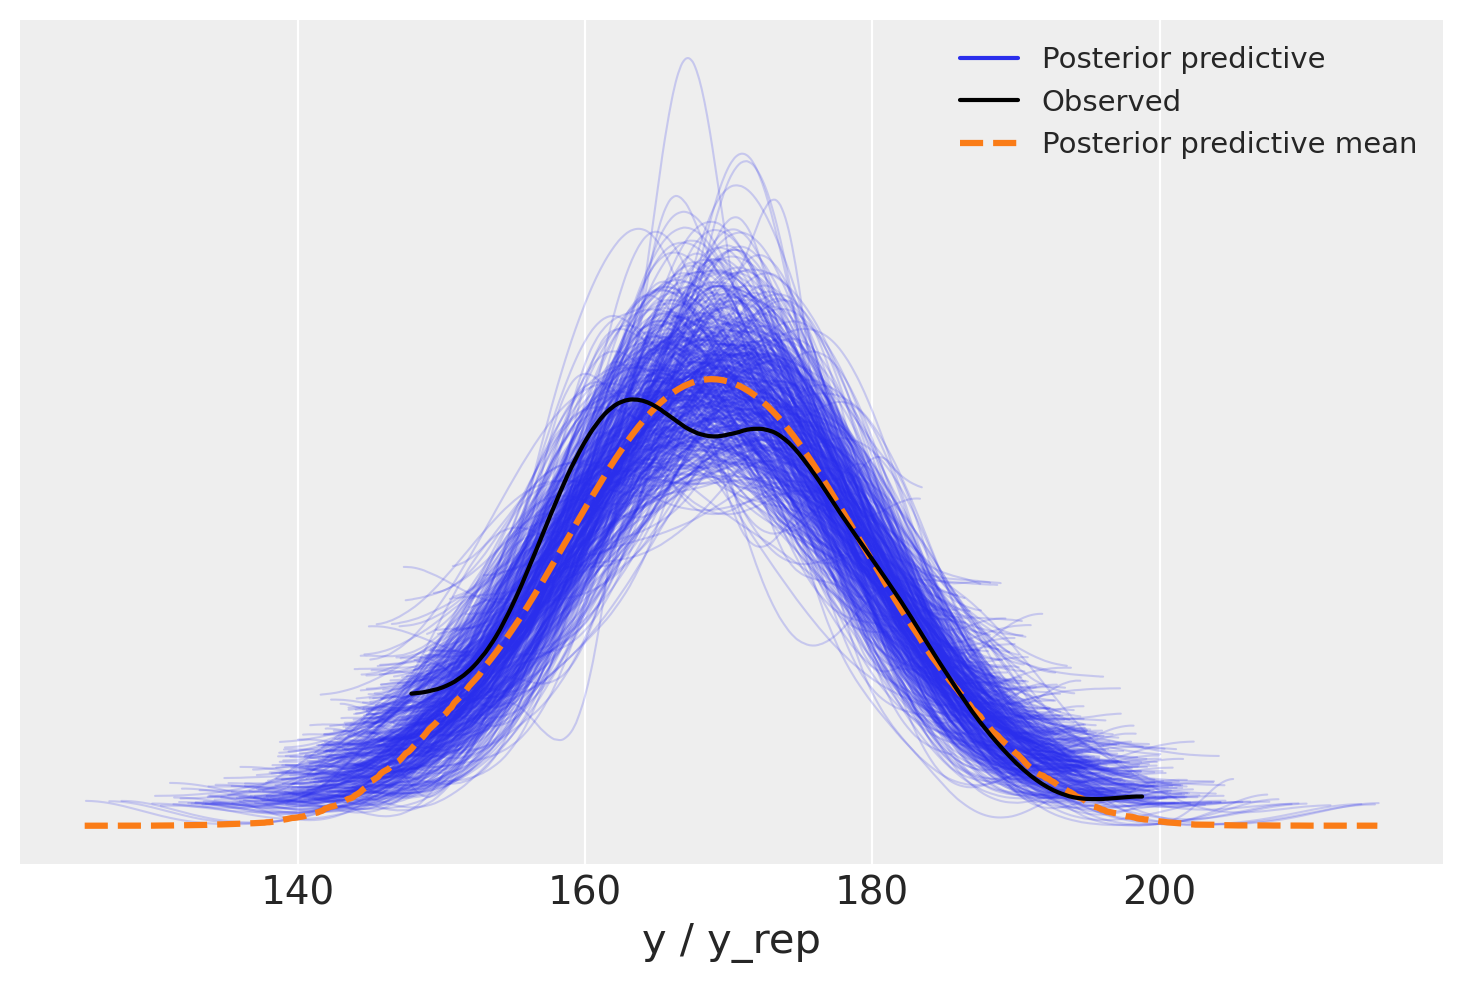

In [9]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=500)

In [10]:
stan_file = os.path.join(
    project_directory, 'stan', 'gaussian_model_prior.stan')

model_gauss = CmdStanModel(stan_file=stan_file)

In [11]:
print(model_gauss.code())

data {
  int<lower=0> N;            // number of observations
}
generated quantities {
  real mu;                   // parameter of interest
  real<lower=0> sigma;       // known standard deviation of y
  array[N] real y_rep;       // prior predictive samples

  // Priors
  mu = normal_rng(175, 5);
  sigma = 10;

  // Generate prior predictive samples
  for (n in 1:N) {
    y_rep[n] = normal_rng(mu, sigma);
  }
}



In [12]:
# Stan data dictionary
stan_data = {
    'N': len(y_observed)
}

In [13]:
prior_predictive_samples = model_gauss.sample(
    data=stan_data, 
    fixed_param=True, 
    iter_sampling=1000, 
    iter_warmup=1, 
    chains=1,
    show_progress=False, 
    show_console=False
)

In [14]:
# Extract the relevant variables
y_rep_samples = prior_predictive_samples.stan_variable('y_rep')
y_rep_flattened = y_rep_samples.flatten()

# Check the statistics of y_rep values
y_rep_mean = np.mean(y_rep_flattened)
y_rep_std = np.std(y_rep_flattened)

print(f'Mean of y_rep: {y_rep_mean}')
print(f'Standard Deviation of y_rep: {y_rep_std}')

Mean of y_rep: 175.04561795
Standard Deviation of y_rep: 11.105448274627541


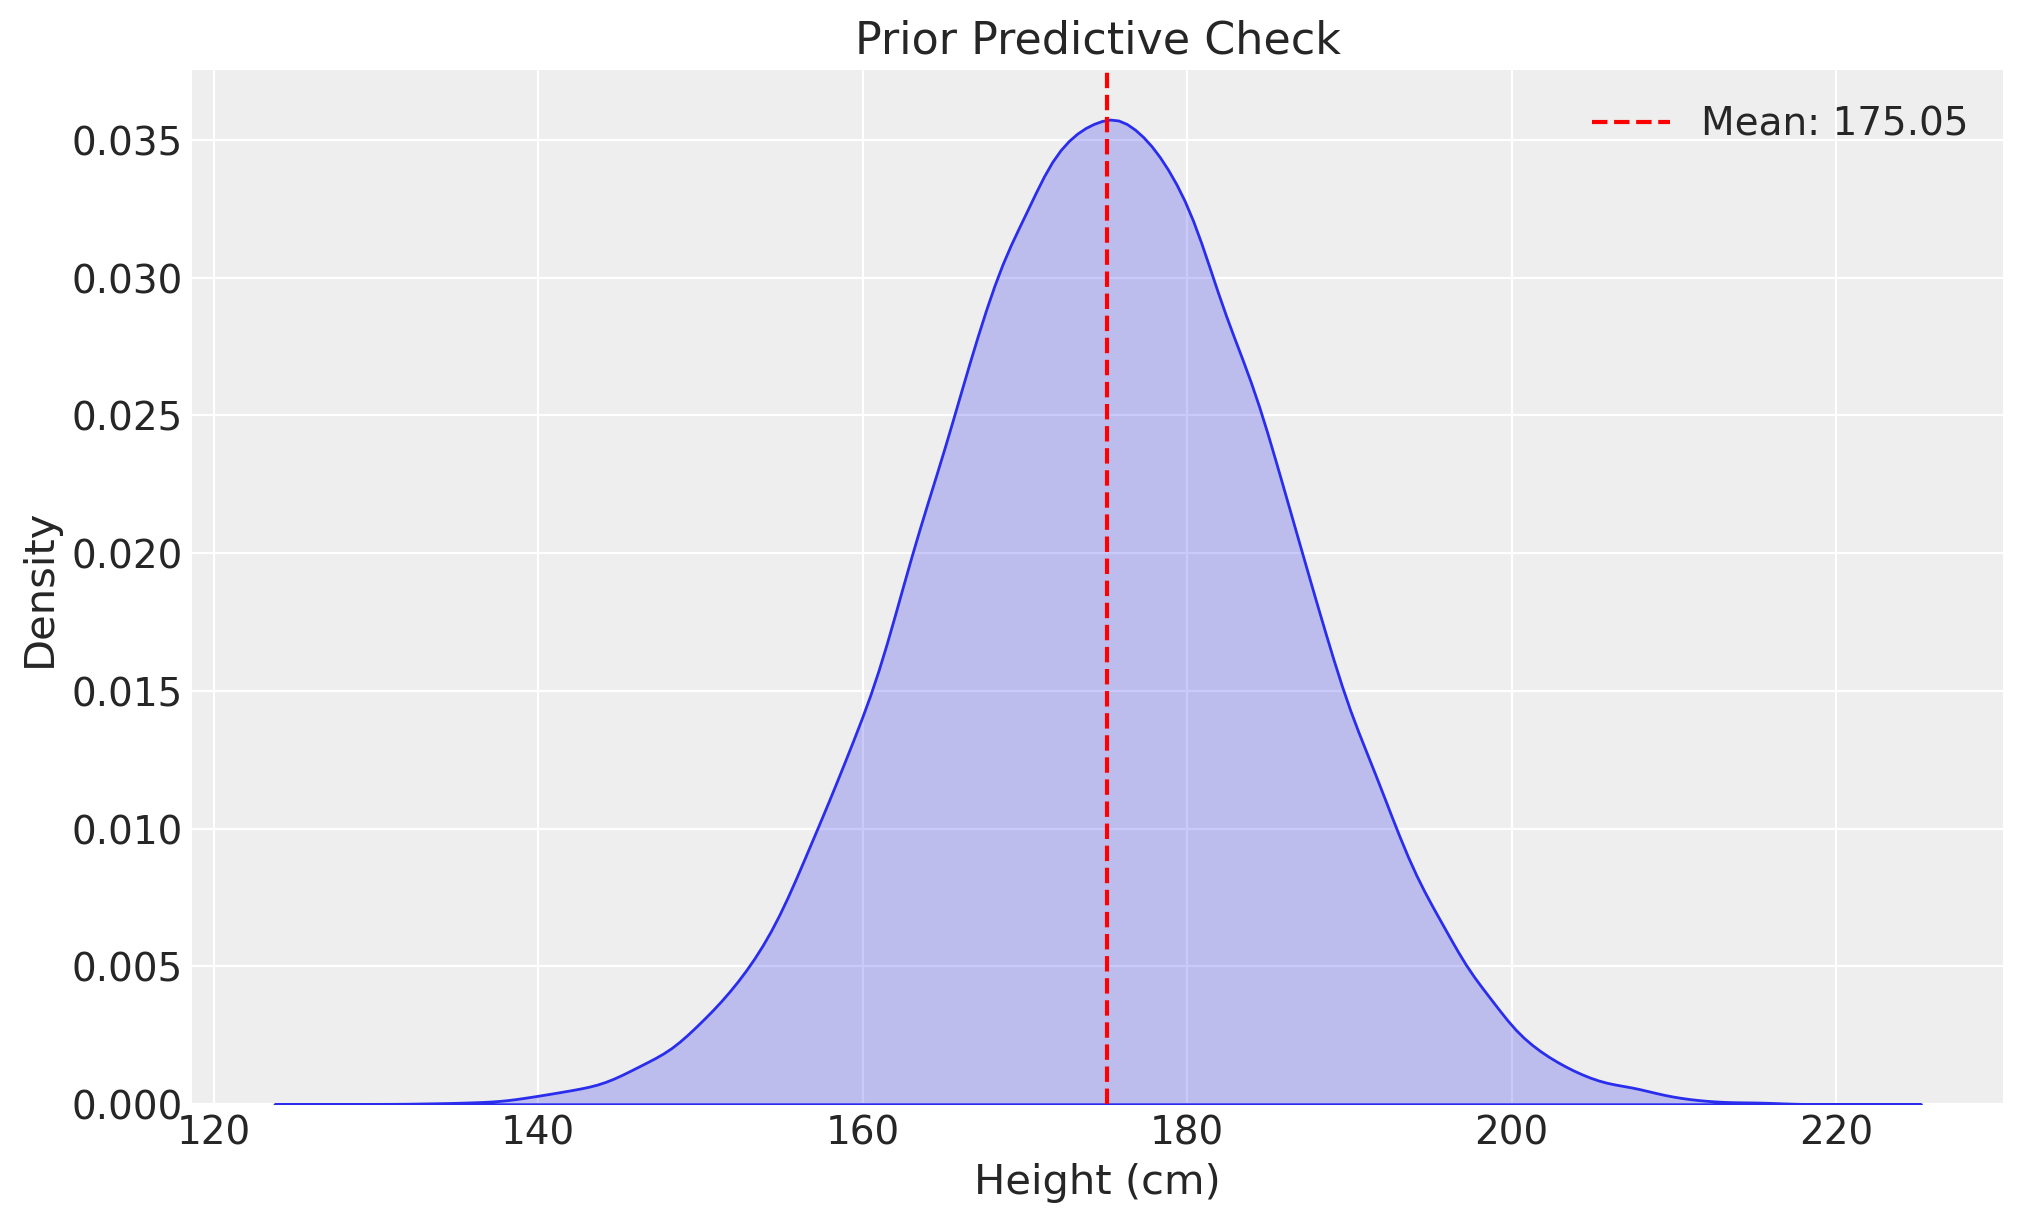

In [15]:
# Create a KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(y_rep_flattened, fill=True)
plt.title('Prior Predictive Check')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.axvline(x=y_rep_mean, color='r', linestyle='--', label=f'Mean: {y_rep_mean:.2f}')
plt.legend()
plt.show()

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p jax

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

jax: 0.4.27

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

cmdstanpy : 1.2.3
arviz     : 0.18.0
seaborn   : 0.13.2
pandas    : 2.2.2
numpy     : 1.26.4
matplotlib: 3.8.4
logging   : 0.5.1.2
scipy     : 1.13.1

Watermark: 2.4.3

